In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\merk2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [100]:
%pip install wordcloud


Note: you may need to restart the kernel to use updated packages.


In [119]:
data = pd.read_csv("amazon_alexa.tsv", delimiter = '\t', quoting = 3)

print(f"Dataset shape : {data.shape}")


Dataset shape : (3150, 5)


In [120]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [121]:
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

In [122]:
#Creating a new column 'length' that will contain the length of the string in 'verified_reviews' column

data['length'] = data['verified_reviews'].apply(len)


In [123]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [124]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3150 non-null   object
 4   feedback          3150 non-null   int64 
 5   length            3150 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 147.8+ KB


# Analysing rating column

In [125]:
data['rating'].value_counts()

5    2286
4     455
1     161
3     152
2      96
Name: rating, dtype: int64

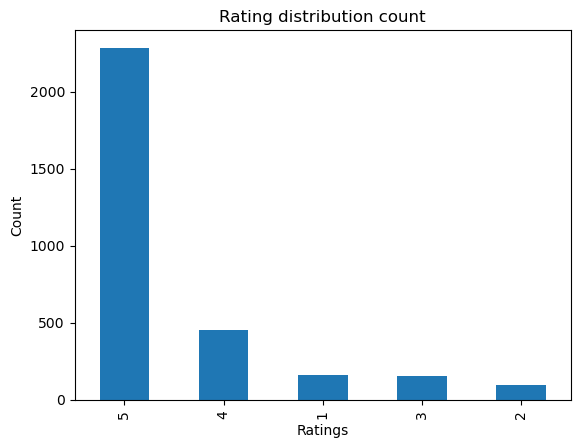

In [126]:
data['rating'].value_counts().plot.bar()
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()


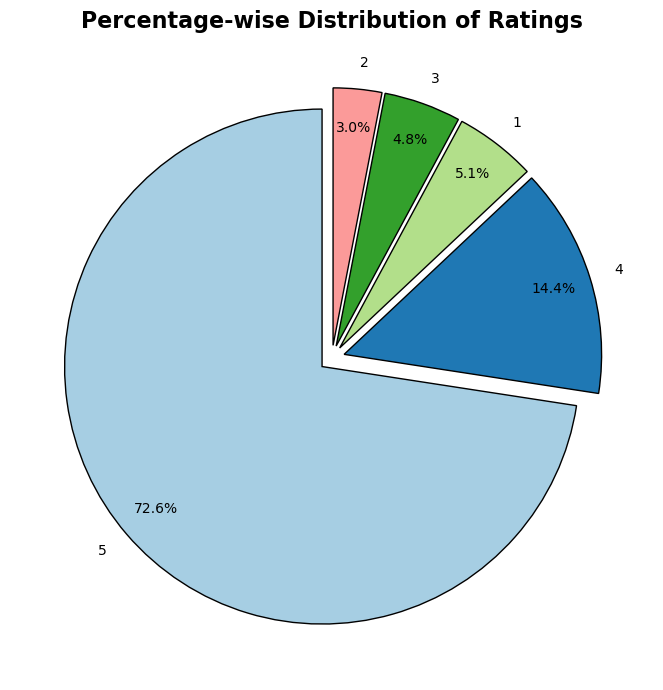

In [127]:
fig = plt.figure(figsize=(7,7))

# Customizing wedge properties
wp = {'linewidth':1, "edgecolor":'black'}

# Calculating percentage distribution of ratings
tags = data['rating'].value_counts() / data.shape[0]

# Exploding all slices slightly
explode = (0.05, 0.05, 0.05, 0.05, 0.05)

# Using a professional color palette
colors = plt.cm.Paired(range(len(tags)))

# Plotting the pie chart
tags.plot(kind='pie', 
          autopct="%1.1f%%", 
          shadow=False, 
          colors=colors, 
          startangle=90, 
          wedgeprops=wp, 
          explode=explode, 
          pctdistance=0.85)

# Equal aspect ratio ensures the pie is drawn as a circle.
plt.gca().set_aspect('equal')  

# Adding title and removing the default label
plt.title('Percentage-wise Distribution of Ratings', fontsize=16, fontweight='bold')
plt.ylabel('')  # Removing the default 'Percentage wise distribution of rating' label

# Displaying the plot
plt.tight_layout()
plt.show()

# Analysing feedback column

In [128]:
data['feedback'].value_counts()

1    2893
0     257
Name: feedback, dtype: int64

In [129]:
review_0 = data[data['feedback'] == 0].iloc[1]['verified_reviews']
print(review_0)

Sound is terrible if u want good music too get a bose


In [130]:
review_1 = data[data['feedback'] == 1].iloc[1]['verified_reviews']
print(review_1)

Loved it!


### 0 is negative 1 is positive

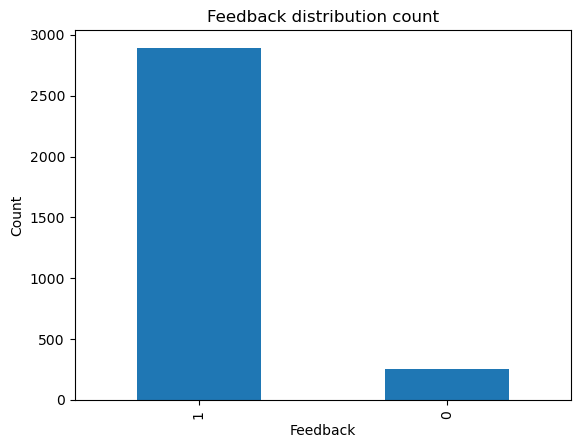

In [131]:
data['feedback'].value_counts().plot.bar()
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

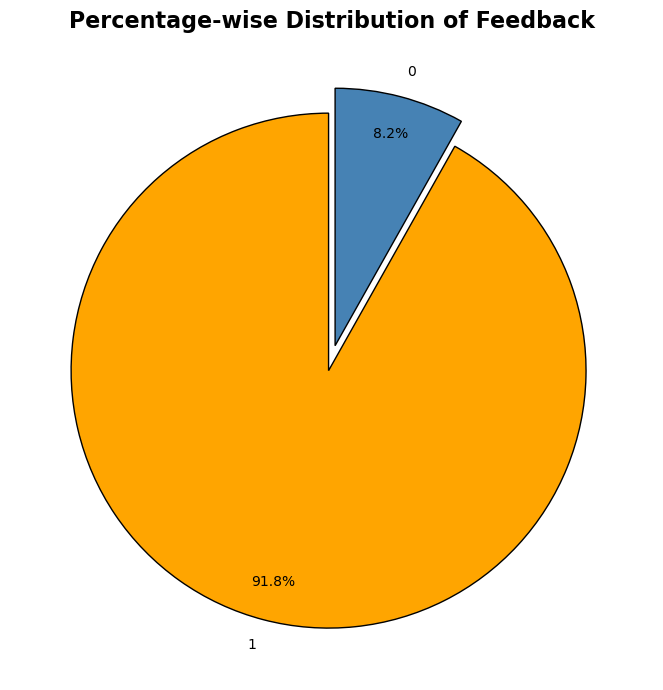

In [132]:
fig = plt.figure(figsize=(7,7))

# Customizing wedge properties
wp = {'linewidth':1, "edgecolor":'black'}

# Calculating percentage distribution of ratings
tags = data['feedback'].value_counts()/data.shape[0]

# Exploding all slices slightly
explode = (0.05, 0.05)

# Using a professional color palette
colors = ['#ffa500', '#4682B4'] 

# Plotting the pie chart
tags.plot(kind='pie', 
          autopct="%1.1f%%", 
          shadow=False, 
          colors=colors, 
          startangle=90, 
          wedgeprops=wp, 
          explode=explode, 
          pctdistance=0.85)

# Equal aspect ratio ensures the pie is drawn as a circle.
plt.gca().set_aspect('equal')  

# Adding title and removing the default label
plt.title('Percentage-wise Distribution of Feedback', fontsize=16, fontweight='bold')
plt.ylabel('')  # Removing the default 'Percentage wise distribution of rating' label

# Displaying the plot
plt.tight_layout()
plt.show()

In [133]:
# Filtering and getting value counts
print("Rating value counts for feedback == 0:")
print(data[data['feedback'] == 0]['rating'].value_counts())

Rating value counts for feedback == 0:
1    161
2     96
Name: rating, dtype: int64


In [134]:
print("Rating value counts for feedback == 1:")
print(data[data['feedback'] == 1]['rating'].value_counts())


Rating value counts for feedback == 1:
5    2286
4     455
3     152
Name: rating, dtype: int64


# analysing variation column

In [135]:
data['variation'].value_counts()

Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
White                            91
Sandstone Fabric                 90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: variation, dtype: int64

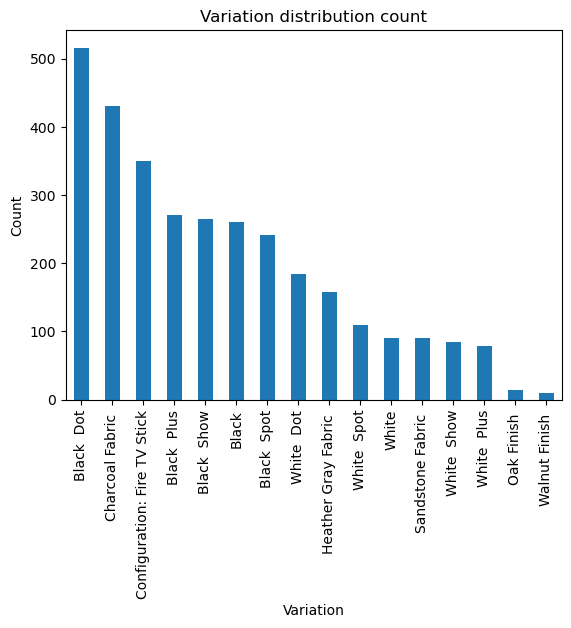

In [136]:
#Bar graph to visualize the total counts of each variation

data['variation'].value_counts().plot.bar()
plt.title('Variation distribution count')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()

In [137]:
#Finding the percentage distribution of each variation - we'll divide the number of records for each variation by total number of records

print(f"Variation value count - percentage distribution: \n{round(data['variation'].value_counts()/data.shape[0]*100,2)}")


Variation value count - percentage distribution: 
Black  Dot                      16.38
Charcoal Fabric                 13.65
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.41
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.98
White  Spot                      3.46
White                            2.89
Sandstone Fabric                 2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: variation, dtype: float64


In [138]:
# Mean rating according to variation

data.groupby('variation')['rating'].mean()


variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.142857
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

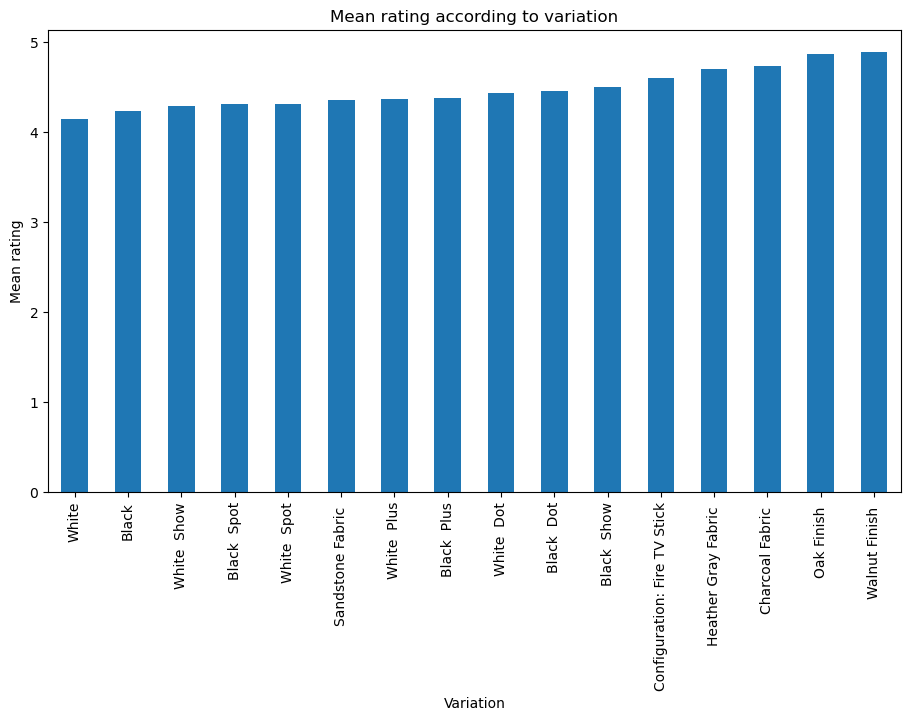

In [139]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar( figsize=(11, 6))
plt.title("Mean rating according to variation")
plt.xlabel('Variation')
plt.ylabel('Mean rating')
plt.show()

# Analysing 'verified_reviews' columns

In [140]:
data['length'].describe()

count    3150.000000
mean      132.673651
std       182.526953
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64

[Text(0.5, 1.0, 'Distribution of length of review ')]

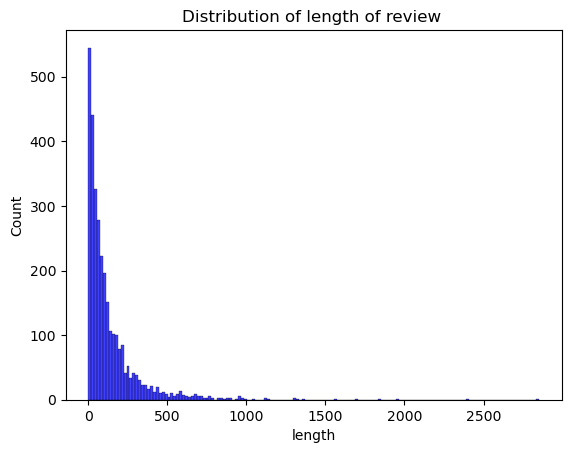

In [141]:
sns.histplot(data['length'],color='blue').set(title='Distribution of length of review ')


In [142]:
data

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5
...,...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"""Perfect for kids, adults and everyone in betw...",1,52
3146,5,30-Jul-18,Black Dot,"""Listening to music, searching locations, chec...",1,137
3147,5,30-Jul-18,Black Dot,"""I do love these things, i have them running m...",1,443
3148,5,30-Jul-18,White Dot,"""Only complaint I have is that the sound quali...",1,382


[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

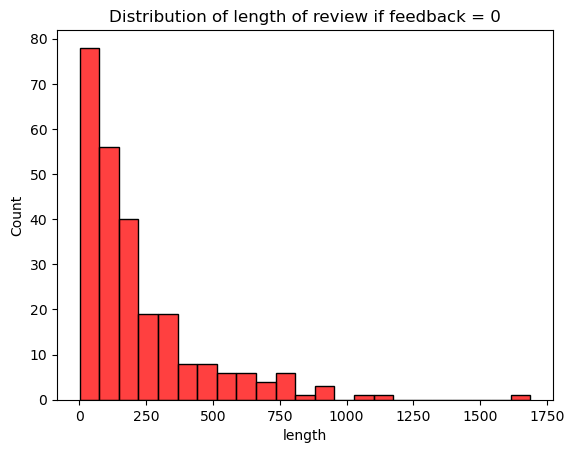

In [143]:
sns.histplot(data[data['feedback']==0]['length'],color='red').set(title='Distribution of length of review if feedback = 0')


[Text(0.5, 1.0, 'Distribution of length of review if feedback = 1')]

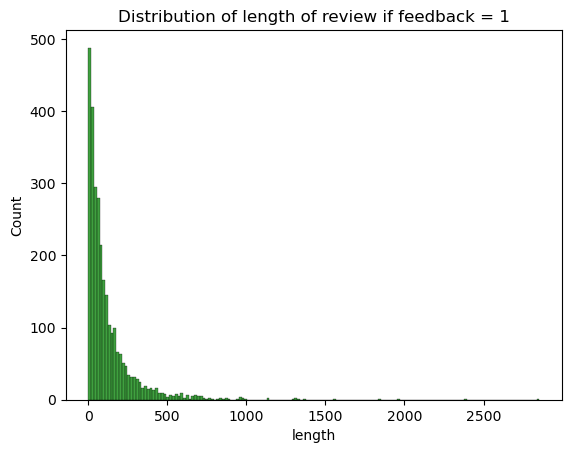

In [144]:
sns.histplot(data[data['feedback']==1]['length'],color='green').set(title='Distribution of length of review if feedback = 1')


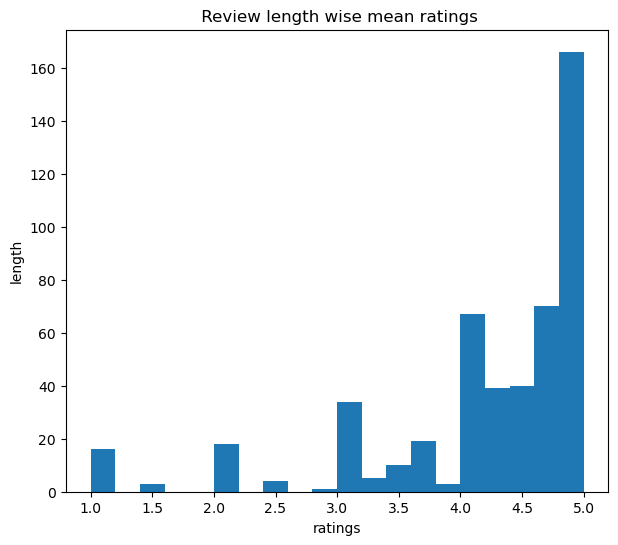

In [145]:
# Lengthwise mean rating
data.groupby('length')['rating'].mean().plot.hist( figsize=(7, 6), bins = 20)
plt.title(" Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

In [146]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.verified_reviews)

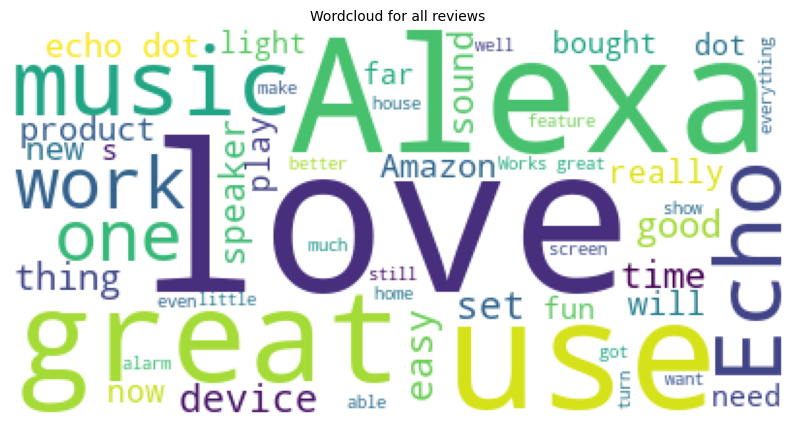

In [147]:
# Combine all reviews
reviews = " ".join([review for review in data['verified_reviews']])
                        
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

In [148]:
# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)

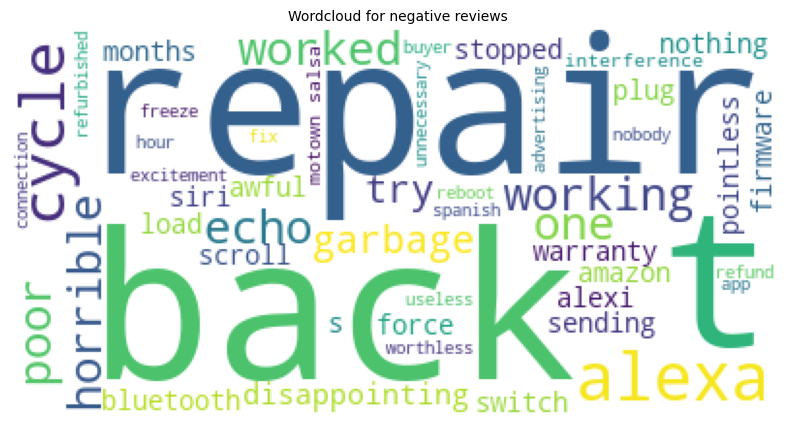

In [149]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

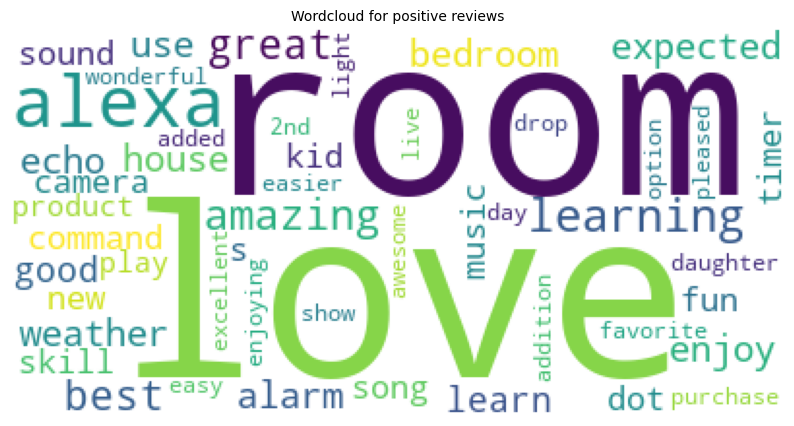

In [150]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

# Preprocessing and Model building

To build the corpus from the 'verified_reviews' we perform the following -

1.Replace any non alphabet characters with a space

2.Covert to lower case and split into words

3.Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus


In [151]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)


In [152]:
cv = CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values


In [153]:
#Saving the Count Vectorizer
pickle.dump(cv, open('countVectorizer.pkl', 'wb'))

In [154]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (3150, 2500)
y shape: (3150,)


In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (2205, 2500)
y train: (2205,)
X test: (945, 2500)
y test: (945,)


In [156]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [157]:
pickle.dump(scaler, open('scaler.pkl', 'wb'))


# model

In [158]:
#random forest

In [159]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [160]:
print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 0.9941043083900227
Testing Accuracy : 0.9375661375661376


In [161]:
#Predicting on the test set
y_preds = model_rf.predict(X_test_scl)

In [162]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)


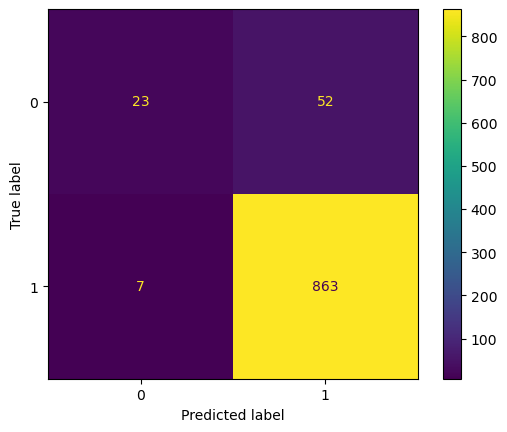

In [163]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

In [164]:
#kfold 
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.9337926779103249
Standard Variance : 0.011633553536113471


In [165]:
# gridsearch
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'bootstrap': True, 'max_depth': 80, 'min_samples_split': 8, 'n_estimators': 100}


In [166]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

Cross validation mean accuracy on train set : 96.98438345841156
Cross validation mean accuracy on test set : 92.29577538078793
Accuracy score for test set : 0.9375661375661376


In [167]:
#xgboost

In [168]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [169]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

Training Accuracy : 0.9700680272108844
Testing Accuracy : 0.9407407407407408


In [170]:
y_preds = model_xgb.predict(X_test)


In [171]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 25  50]
 [ 10 860]]


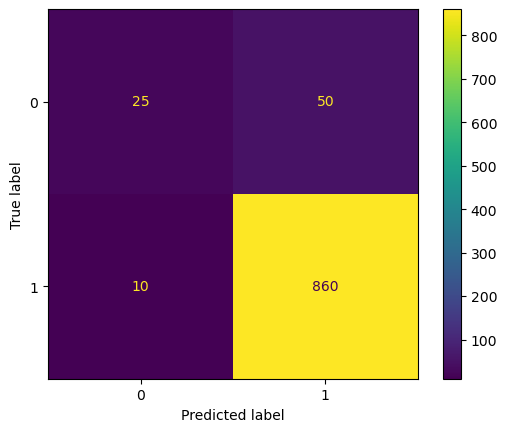

In [172]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [173]:
#Saving the XGBoost classifier
pickle.dump(model_xgb, open('model_xgb.pkl', 'wb'))

In [174]:
#decision tree classifier

In [175]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [176]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_dt.score(X_train_scl, y_train))
print("Testing Accuracy :", model_dt.score(X_test_scl, y_test))

Training Accuracy : 0.9941043083900227
Testing Accuracy : 0.9132275132275133


In [177]:
y_preds = model_dt.predict(X_test)


In [178]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 35  40]
 [ 56 814]]


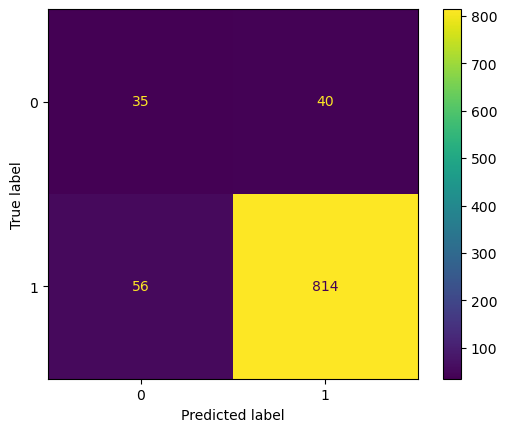

In [179]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()

In [180]:
from sklearn.naive_bayes import MultinomialNB

In [181]:
mnb = MultinomialNB()
clfs = {
    'NB' : mnb,
}


In [193]:
def train_classifier(clf,X_train_scl,y_train,X_test,y_test):
    clf.fit(X_train_scl,y_train)
    y_pred1 = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred1)
    return accuracy, y_pred1

In [197]:
accuracy, y_pred1 = train_classifier(mnb, X_train_scl, y_train, X_test, y_test)


In [198]:
cm = confusion_matrix(y_test, y_pred1)
print(cm)

[[ 15  60]
 [  6 864]]


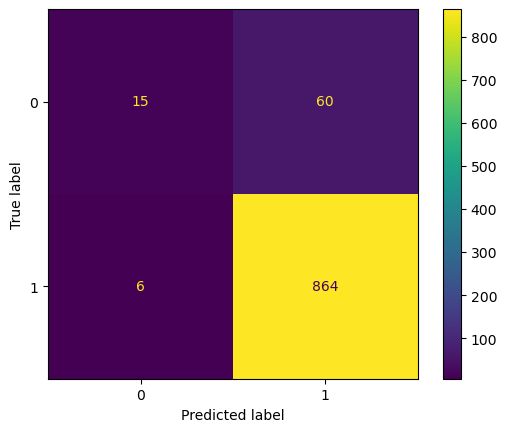

In [199]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()

Accuracy: 0.9301587301587302


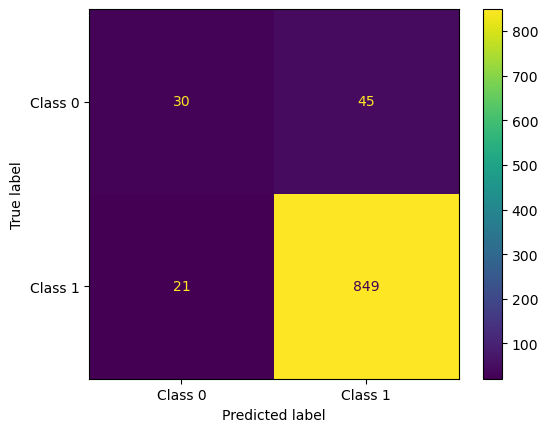

In [200]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define the parameter grid
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100],
    'fit_prior': [True, False]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy')

# Fit the model
grid_search.fit(X_train_scl, y_train)

# Get the best estimator
best_mnb = grid_search.best_estimator_

# Predict using the best estimator
y_pred1 = best_mnb.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred1)
print(f'Accuracy: {accuracy}')

# Calculate and plot confusion matrix
cm = confusion_matrix(y_test, y_pred1)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
cm_display.plot()
plt.show()

In [202]:
pip install imbalanced-learn

     ------------------------------------ 258.3/258.3 kB 230.1 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [203]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_scl_bal, y_train_bal = smote.fit_resample(X_train_scl, y_train)


Accuracy: 0.8613756613756614


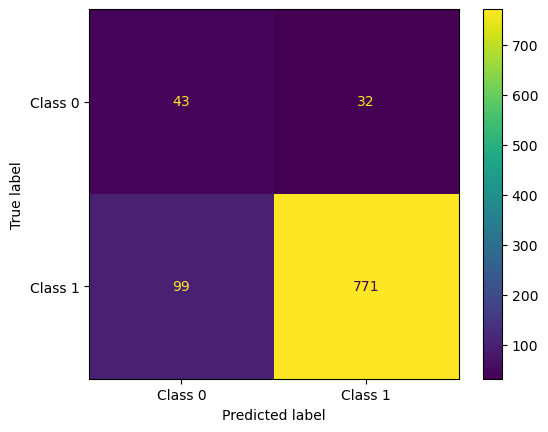

In [204]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Fit the model
best_mnb.fit(X_train_scl_bal, y_train_bal)

# Predict probabilities
y_proba = best_mnb.predict_proba(X_test)[:, 1]

# Adjust the threshold
threshold = 0.7
y_pred_adjusted = (y_proba >= threshold).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_adjusted)
print(f'Accuracy: {accuracy}')

# Calculate and plot confusion matrix
cm = confusion_matrix(y_test, y_pred_adjusted)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
cm_display.plot()
plt.show()


Accuracy with threshold 0.8: 0.8328042328042328


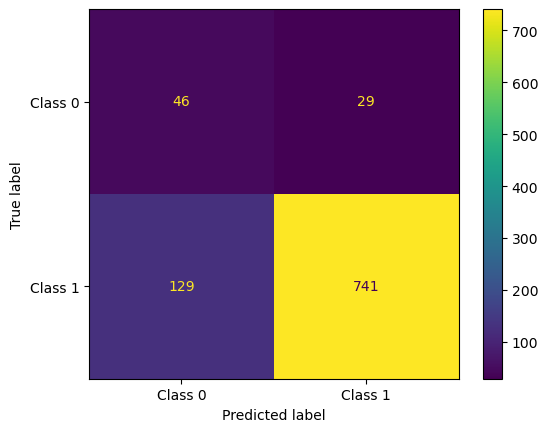

In [223]:
# Try different threshold values
best_threshold = 0.8
y_pred_adjusted_best = (y_proba >= best_threshold).astype(int)

# Calculate accuracy
accuracy_best = accuracy_score(y_test, y_pred_adjusted_best)
print(f'Accuracy with threshold {best_threshold}: {accuracy_best}')

# Calculate and plot confusion matrix
cm_best = confusion_matrix(y_test, y_pred_adjusted_best)
cm_display_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=['Class 0', 'Class 1'])
cm_display_best.plot()
plt.show()


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Random Forest Accuracy: 0.9132275132275133


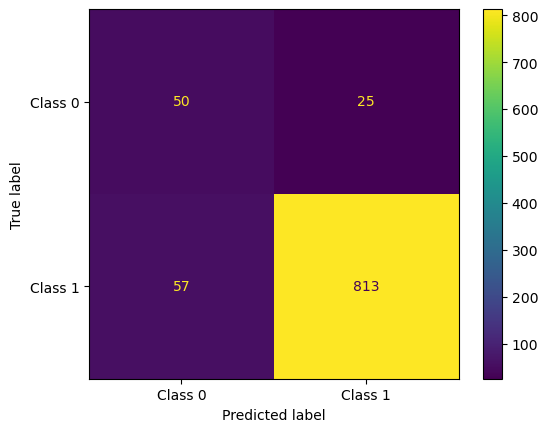

In [224]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Random Forest classifier
rf = RandomForestClassifier()

# Perform grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scl_bal, y_train_bal)

# Best estimator
best_rf = grid_search.best_estimator_

# Fit the best model
best_rf.fit(X_train_scl_bal, y_train_bal)

# Predict probabilities
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

# Adjust the threshold
y_pred_adjusted_rf = (y_proba_rf >= threshold).astype(int)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_adjusted_rf)
print(f'Random Forest Accuracy: {accuracy_rf}')

# Calculate and plot confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_adjusted_rf)
cm_display_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Class 0', 'Class 1'])
cm_display_rf.plot()
plt.show()


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Random Forest Accuracy: 0.8624338624338624


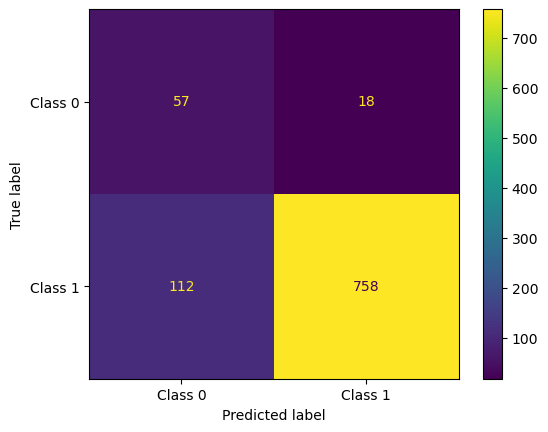

Model saved to best_random_forest_model.pkl


In [227]:
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Random Forest classifier
rf = RandomForestClassifier()

# Perform grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scl_bal, y_train_bal)

# Best estimator
best_rf = grid_search.best_estimator_

# Fit the best model
best_rf.fit(X_train_scl_bal, y_train_bal)

# Predict probabilities
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

# Adjust the threshold
threshold = 0.8  # You can adjust this threshold as needed
y_pred_adjusted_rf = (y_proba_rf >= threshold).astype(int)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_adjusted_rf)
print(f'Random Forest Accuracy: {accuracy_rf}')

# Calculate and plot confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_adjusted_rf)
cm_display_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Class 0', 'Class 1'])
cm_display_rf.plot()
plt.show()

# Save the model using pickle
model_filename = 'best_random_forest_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(best_rf, file)

print(f'Model saved to {model_filename}')
